In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.applications.xception import Xception
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, merge, Input
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D
from keras.utils import np_utils
from keras.models import model_from_json
from keras import backend as K
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.applications.xception import preprocess_input, decode_predictions
import random
import h5py

%matplotlib inline

C:\Users\yijig\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# 构建网络
from sklearn.utils import shuffle
np.random.seed(42)

X_train = []
X_test = []

for filename in ["../features/feature_xception.h5", "../features/feature_densenet201.h5", "../features/feature_inception_v3.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        Y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, Y_train = shuffle(X_train, Y_train)

In [3]:
# 建立顶层网络结构
input_tensor = Input(X_train.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [4]:
#训练模型并保存顶层网络参数
filepath="merged_weight_1.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
callbacks_list = [checkpoint]
history = model.fit(X_train, Y_train, batch_size=128, epochs=20, validation_split=0.2, shuffle=True,
         callbacks=callbacks_list)
model.save_weights("merged_weights_1s.h5")

Train on 19968 samples, validate on 4993 samples
Epoch 1/20
19968/19968 [==============================] - 2s 119us/step - loss: 0.0643 - acc: 0.9817 - val_loss: 0.0168 - val_acc: 0.9962

Epoch 00001: val_loss improved from inf to 0.01683, saving model to merged_weight_1.h5
Epoch 2/20
19968/19968 [==============================] - 2s 106us/step - loss: 0.0178 - acc: 0.9946 - val_loss: 0.0125 - val_acc: 0.9964

Epoch 00002: val_loss improved from 0.01683 to 0.01252, saving model to merged_weight_1.h5
Epoch 3/20
19968/19968 [==============================] - 2s 108us/step - loss: 0.0141 - acc: 0.9956 - val_loss: 0.0114 - val_acc: 0.9966

Epoch 00003: val_loss improved from 0.01252 to 0.01144, saving model to merged_weight_1.h5
Epoch 4/20
19968/19968 [==============================] - 2s 111us/step - loss: 0.0130 - acc: 0.9958 - val_loss: 0.0115 - val_acc: 0.9968

Epoch 00004: val_loss did not improve
Epoch 5/20
19968/19968 [==============================] - 2s 117us/step - loss: 0.0116 -

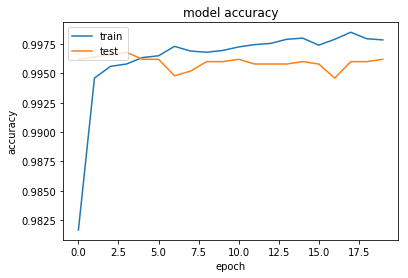

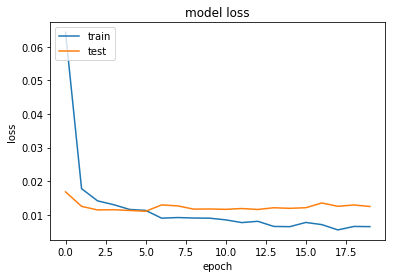

In [6]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('learning_fig.png')

In [5]:
model.load_weights('merged_weights.h5')
y_pred = model.predict(X_test, verbose=1)
y_test = y_pred.clip(min=0.005, max=0.995)

12500/12500 [==============================] - 0s 14us/step


In [9]:
os.chdir('../dogs_vs_cats-master/')

In [10]:
os.getcwd()

'D:\\Machine Learning\\dogs_vs_cats-master'

In [11]:
def data_symbol_link():
    work_dir  = os.getcwd()
    train_dir = work_dir + "/train/"
    test_dir  = work_dir + "/test/"
    data_dir  = work_dir + "/data/"
    
    if(os.path.exists(data_dir)):
        shutil.rmtree(data_dir)
        
    split_train_dir = work_dir+"/data/train"
    split_test_dir  = work_dir+"/data/test"
    os.mkdir(data_dir)
    
    os.mkdir(split_train_dir)
    os.mkdir(split_train_dir+"/dog")
    os.mkdir(split_train_dir+"/cat")
    os.mkdir(split_test_dir)
    os.mkdir(split_test_dir+"/test")
        
    train_files = os.listdir(train_dir)    
    num_train_files = len(train_files)
    for i in tqdm(range(num_train_files)):
        file = train_files[i]
        if "dog" in file.split('.'):
            os.symlink(train_dir+file, split_train_dir+"/dog/"+file)
        else:
            os.symlink(train_dir+file, split_train_dir+"/cat/"+file)
    
    test_files = os.listdir(test_dir)    
    num_test_files = len(test_files)
    for i in tqdm(range(num_test_files)):
        file = test_files[i]
        os.symlink(test_dir+file, split_test_dir+"/test/"+file)
        
    return split_train_dir, split_test_dir  

In [14]:
from tqdm import tqdm
train_data, test_data = data_symbol_link()

  0%|                                                                                        | 0/25000 [00:00<?, ?it/s]


OSError: symbolic link privilege not held

In [6]:
df = pd.read_csv("sample_submission.csv")

gen = ImageDataGenerator()
test_generator = gen.flow_from_directory('../dogs_vs_cats-master/test/', (224, 224), shuffle=False, 
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_test[i])

df.to_csv('pred_20180824.csv', index=None)
df.head(10)

Found 0 images belonging to 0 classes.


,id,label
0,1,0.5
1,2,0.5
2,3,0.5
3,4,0.5
4,5,0.5
5,6,0.5
6,7,0.5
7,8,0.5
8,9,0.5
9,10,0.5
